# Studying FEL UQ - Creating Basic NN Models with Quantile Regression

### In this notebook, the following is done: 
A surrogate model of FEL pulse energy at the SLAC LCLS is trained on archiver (historical) data. The data spans several years of operation. The dataset inputs several accelerator "inputs" which result in an "output" pulse energy.

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
mpl.rc('font', **font)


import QuantRegUtils as qru

#### Load Data

In [2]:
PATH = "datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

#### Take a look at the input variables

In [3]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
## View the names and indicies of each variable
if view:
    for i, v in enumerate(variable_names):
        print(i, v)

#### Data manipulations

The following cell converts the dataframe to numpy arrays and applies the following cuts to the data: 

1) Removing extraneous data: no output values should be less than 0 (units) or greater than 5 (units).


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (281600, 76)
Output values: (281600,)


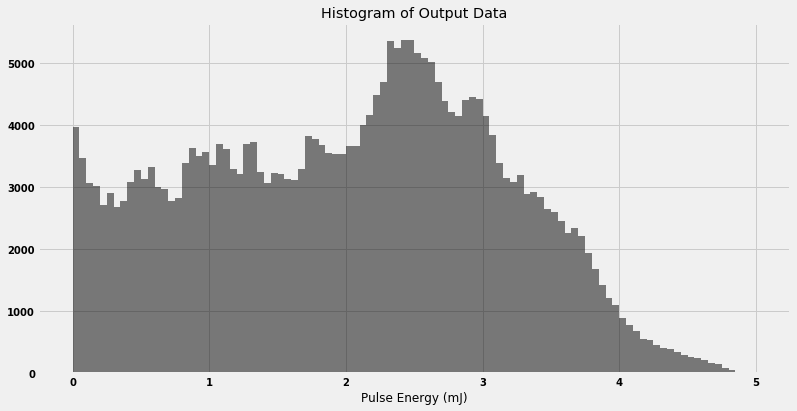

In [30]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))

## 
n = 281600

input_data = input_data[:n, :]
output_data = output_data[:n]

print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()

#### Scaling information will be needed later, should be saved and set up for use in training and model eval.

In [31]:
PATH = ""
MODEL_NAME = "Interp/"
loading = False
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME + "x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME + "y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME + "y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, scd = qru.scaling_and_dict(input_data, output_data)

#### Examine Data

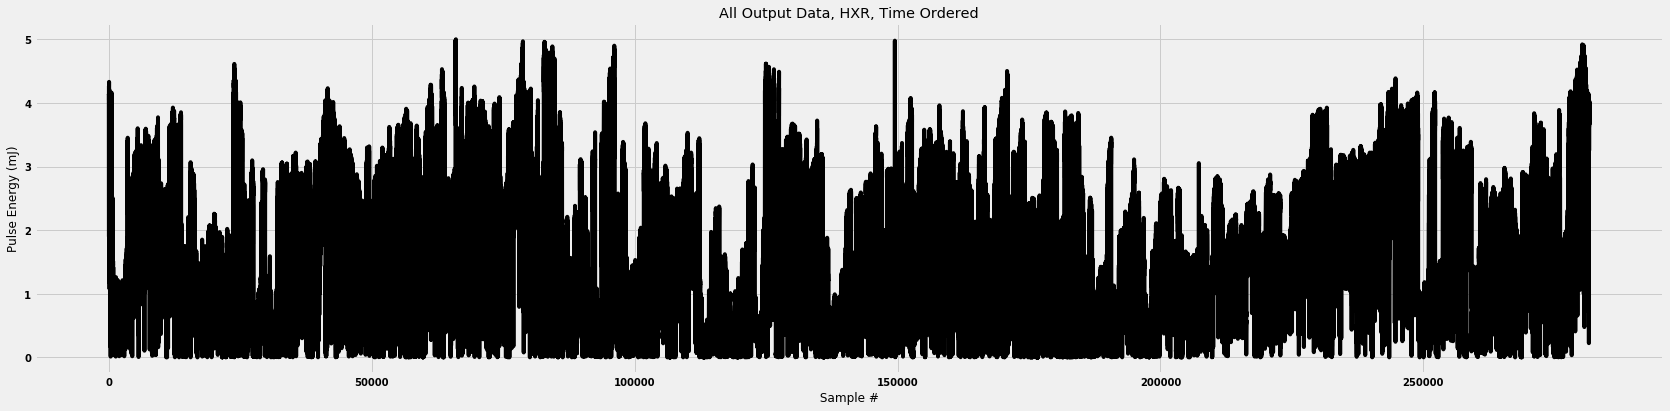

In [32]:
## Take a look at all of the output data
plt.figure(figsize= (26,6))
plt.plot(output_data, color = colors[0])
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel(" Sample # ")
plt.title("All Output Data, HXR, Time Ordered")
plt.show()

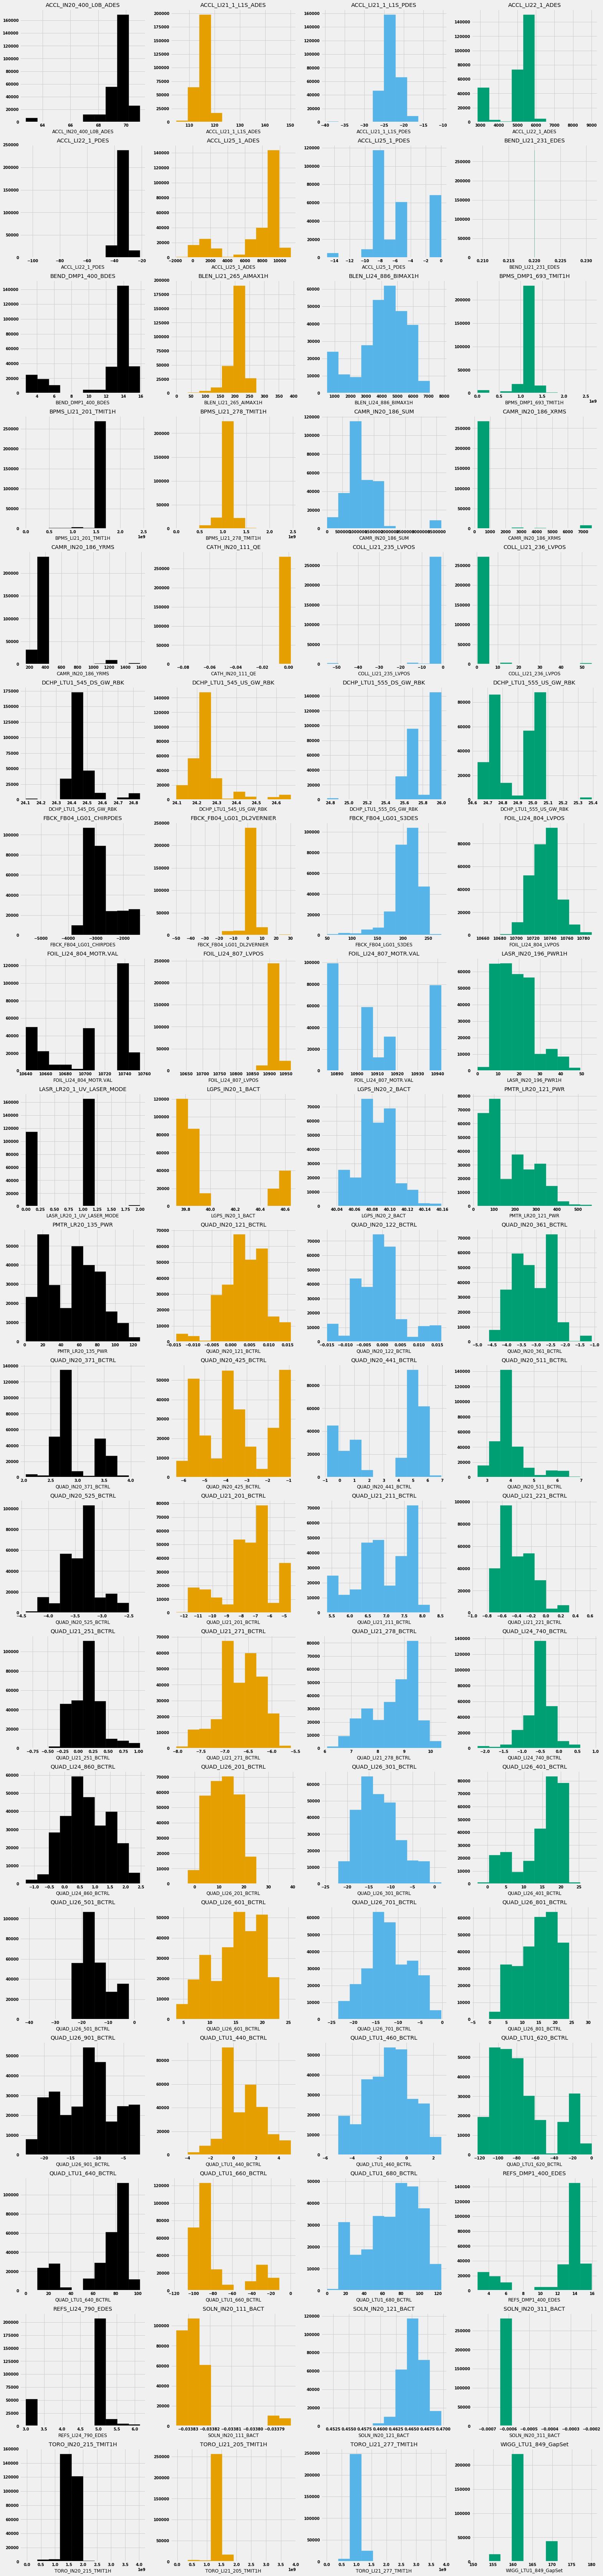

In [33]:
fig, axs = plt.subplots(19, 4, figsize = (24,int(6*19)))
counter = 0
for i in range(19):
    for j in range(4):

        axs[i,j].hist(input_data[:,counter], facecolor = colors[j], ec= colors[j])
        axs[i,j].set_title(variable_names[counter])
        axs[i,j].set_xlabel(variable_names[counter])
        counter = counter + 1
        plt.suptitle("")

plt.show()

## Training the Base Models

To make a nice apples-to-apples comparison, each model will be trained on the same data. Then we can see how well it performs on the same test samples!

In [34]:
n = np.shape(input_data)[0]

(2000,)
(10000,)
(8000, 76)
(8000,)


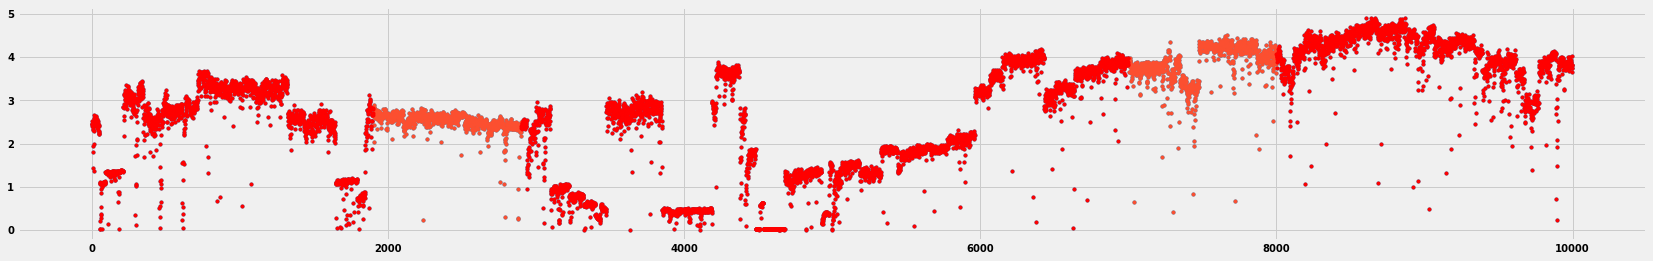

In [36]:
input_cut = input_data[n-10000:]
output_cut = output_data[n-10000:]
allinds = np.arange(0,10000)

a = 1900
b = 2900

c = 7000
d = 8000

inds_removed = np.concatenate( (np.arange(a,b), np.arange(c,d)))


plt.figure(figsize= (26,4))

plt.plot(output_cut, ".")
plt.plot(inds_removed, output_cut[inds_removed], '.')
print(np.shape(inds_removed))
print(np.shape(output_cut))

input_rem = np.delete(input_cut, inds_removed, axis = 0)
print(np.shape(input_rem))

output_rem = np.delete(output_cut, inds_removed)
print(np.shape(output_rem))

remaining = np.delete(allinds, inds_removed)

plt.plot(remaining, output_rem, '.r')
plt.show()

0.452238916807054


(array([  3.,   1.,   0.,   4.,   4.,  13.,  52., 196., 359., 368.]),
 array([0.40803761, 0.81959217, 1.23114674, 1.6427013 , 2.05425587,
        2.46581043, 2.877365  , 3.28891956, 3.70047412, 4.11202869,
        4.52358325]),
 <a list of 10 Patch objects>)

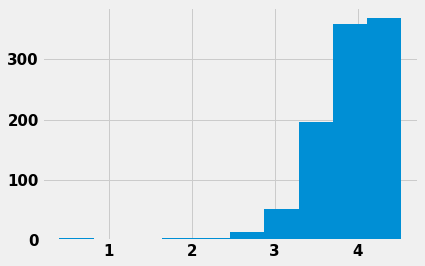

In [88]:
print(np.std(output_cut[c:d]))
plt.hist(output_cut[c:d])

In [89]:
np.min(output_cut[c:d])/np.mean(output_cut[c:d])

0.10543653543250776

In [59]:
training_models = False
PATH = ""
if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_rem, output_rem, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = input_cut

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = output_cut

    with open(PATH + "Interp/inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "Interp/outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096
    PATH = "Interp/"

    median = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "median_pred_0.1_", QUANTILE = 0.5)
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    upper = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "upper_pred_0.1_", QUANTILE = 0.975)
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    lower = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "lower_pred_0.1_", QUANTILE = 0.025)
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)
    
    print("Completed")
else:

    PATH = "/global/cfs/cdirs/m669/lgupta/datasets/FEL/knet2_76D/"
    MODEL_NAME = "QRRemove/FEL_NN_101220_"
    NN = MODEL_NAME + "Model_Weights.h5"
    LB = MODEL_NAME + "LB_Model_Weights.h5"
    UB = MODEL_NAME + "UB_Model_Weights.h5"

#     with open(PATH + "Interp/_0.1_inputs.pkl", 'rb') as f:
#         input_dict = pickle.load(f, encoding="utf-8")

#     with open(PATH + "Interp/_0.1_outputs.pkl", 'rb') as f:
#         output_dict = pickle.load(f)

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = scd)   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = scd)   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = scd)   
    lower.load()
    print("All models loaded")
    


    
    

All models loaded


Let's look at the performance!!

In [75]:
out = output_cut
median_pred = median.evaluate(input_cut)
ub_pred = upper.evaluate(input_cut)
lb_pred = lower.evaluate(input_cut)


Do our 95% confidence intervals actually include 95% of the measurements?

In [76]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))

The percent of measured values within the confidence interval is: 85.63%


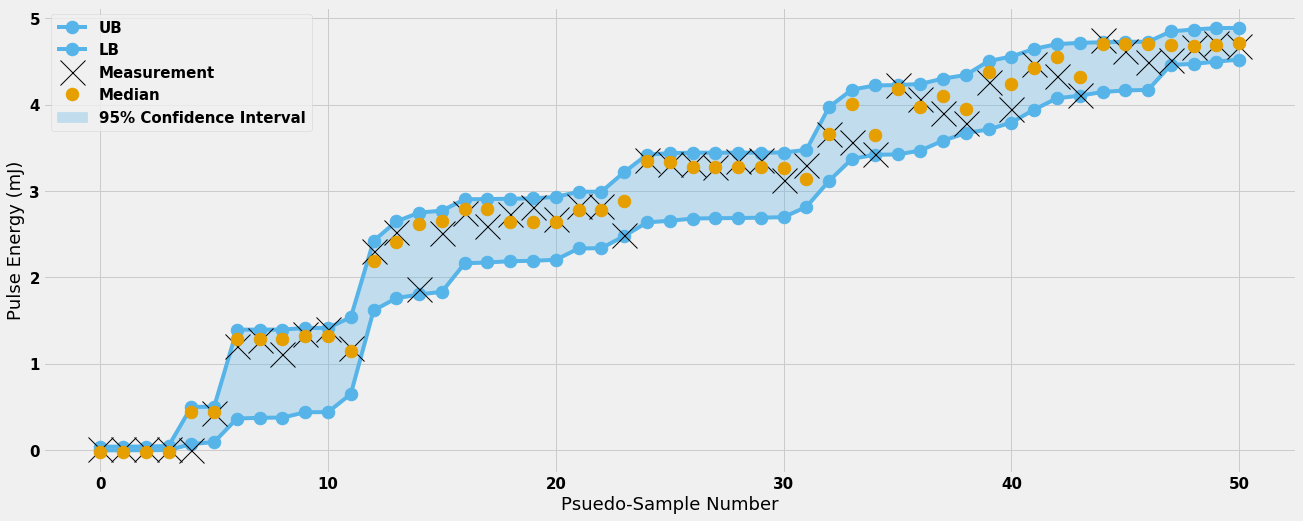

In [77]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

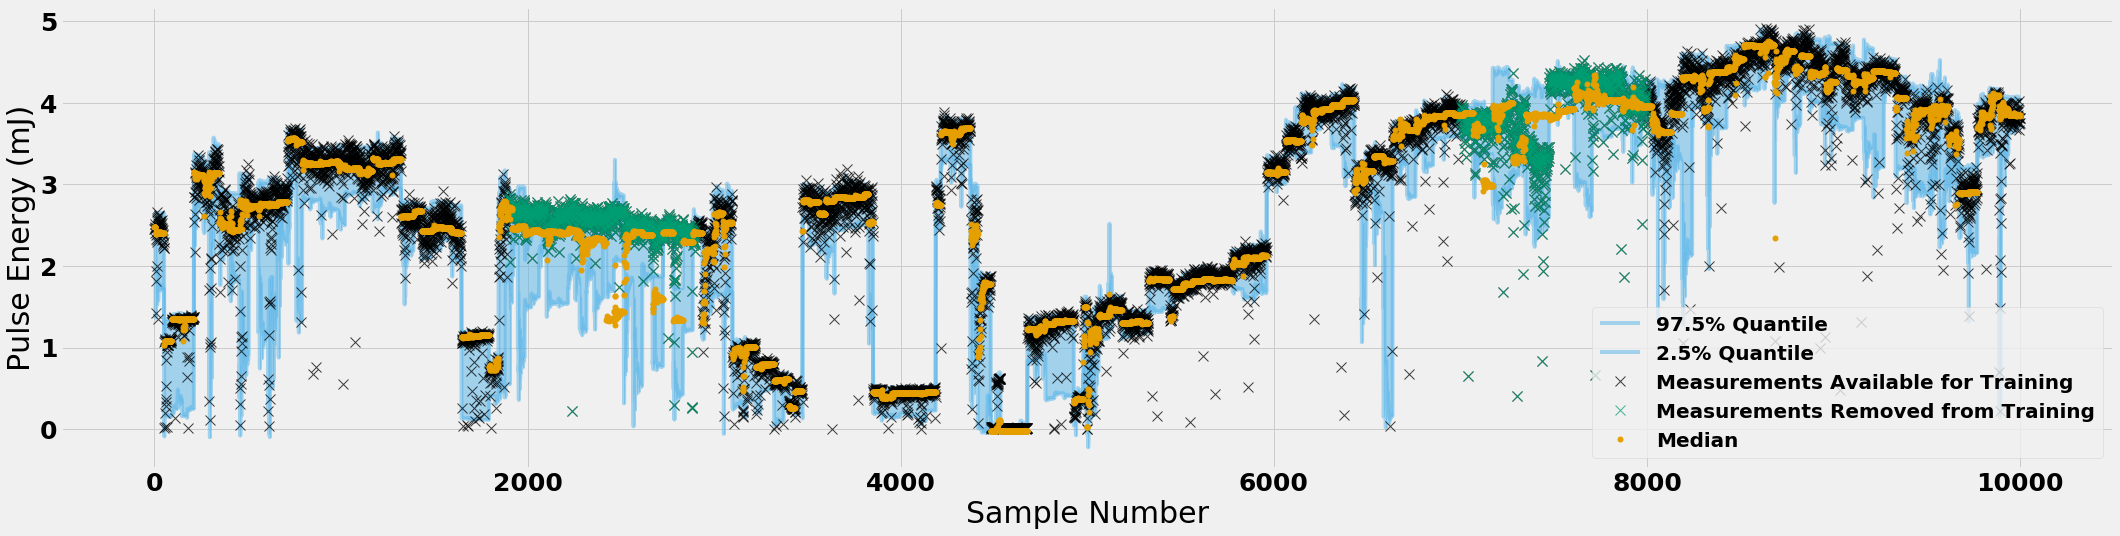

In [93]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)

markersize = 10
plt.figure(figsize = (30, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "97.5% Quantile", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "2.5% Quantile",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)
#plt.xlim(1500,3500)
#plt.xlim(6500,8500)
plt.legend(fontsize = 20)
plt.xlabel("Sample Number")
plt.ylabel("Pulse Energy (mJ)")
plt.tight_layout()
#plt.title("Quantile Regression Predictions")
plt.savefig("interpolation_1.png", transparent = True)
plt.show()

In [ ]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)

markersize = 10
plt.figure(figsize = (30, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "97.5% Quantile", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "2.5% Quantile",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)
#plt.xlim(1500,3500)
#plt.xlim(6500,8500)
plt.legend(fontsize = 20)
plt.xlabel("Sample Number")
plt.ylabel("Pulse Energy (mJ)")
plt.tight_layout()
#plt.title("Quantile Regression Predictions")
plt.savefig("interpolation_1.png", transparent = True)
plt.show()

mean  0.4190832233902834
std  0.08070092037771058


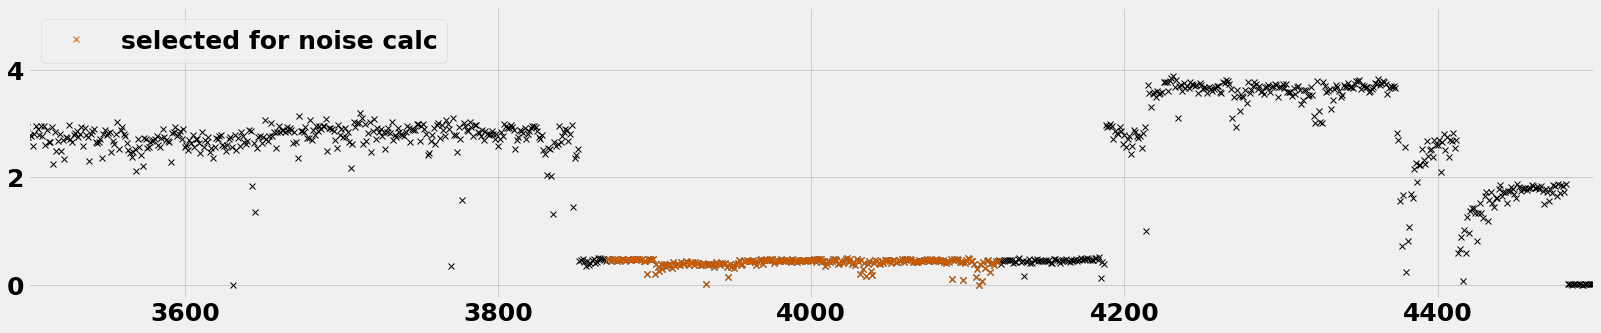

In [118]:
plt.figure(figsize = (25,5))
plt.plot(allinds, out, 'x', color = colors[0])
plt.plot(np.arange(3870,4120),out[3870:4120], 'x', color = colors[4], label = "selected for noise calc")
plt.xlim(3500,4500)
plt.legend(loc = "upper left")
print("mean ", np.mean(out[3870:4120]))
print("std ", np.std(out[3870:4120]))

mean  2.731910406497211
std  0.29786646082692303


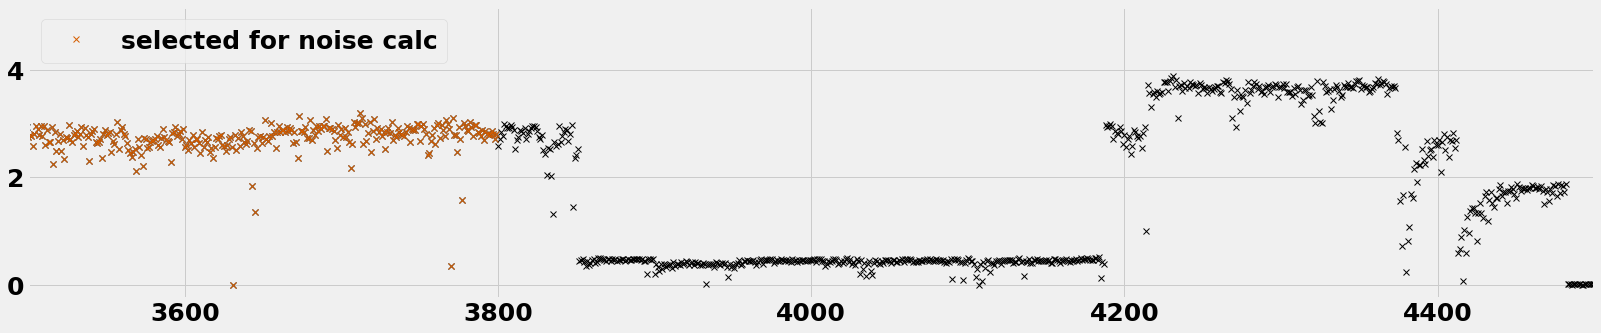

In [119]:
plt.figure(figsize = (25,5))
plt.plot(allinds, out, 'x', color = colors[0])
plt.plot(np.arange(3500,3800),out[3500:3800], 'x', color = colors[4], label = "selected for noise calc")
plt.xlim(3500,4500)
plt.legend(loc = "upper left")
print("mean ", np.mean(out[3500:3800]))
print("std ", np.std(out[3500:3800]))

In [120]:
0.29786646082692303/2.731910406497211

0.10903229480678327

In [64]:
out = output_cut[inds_removed]
median_pred = median.evaluate(input_cut[inds_removed])
ub_pred = upper.evaluate(input_cut[inds_removed])
lb_pred = lower.evaluate(input_cut[inds_removed])
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
mse, mae = qru.calc_mse_and_mae(median_pred[:,0], out)
print("MSE:", mse)
print("MAE:", mae)

The percent of measured values within the confidence interval is: 53.35%
MSE: 0.24165262117497116
MSE: 0.3373187331155357


In [ ]:
qru.plot_individual_points(ub_pred, lb_pred, median_pred, out, cols = 4, rows = 7)

And finally, some errors: mean squared error and mean absolute error. Remember, we want these to be small! :)

Let's also look at the overall performance of these models on the whole dataset.

In [ ]:
out = output_data
median_pred = median.evaluate(input_data)
ub_pred = upper.evaluate(input_data)
lb_pred = lower.evaluate(input_data)


In [ ]:
qru.basic_plotting(ub_pred[-1000:,:], lb_pred[-1000:,:], median_pred[-1000:,:], out[-1000:])
plt.title("Prediction on All Data (last 1k samples)")
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel("Sample #")
plt.show()

In [ ]:
qru.basic_plotting(ub_pred[-5000:,:], lb_pred[-5000:,:], median_pred[-5000:,:], out[-5000:])
plt.title("Prediction on All Data (last 5k samples)")
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel("Sample #")
plt.show()

(2000,)
(10000,)
(8000, 76)
(8000,)


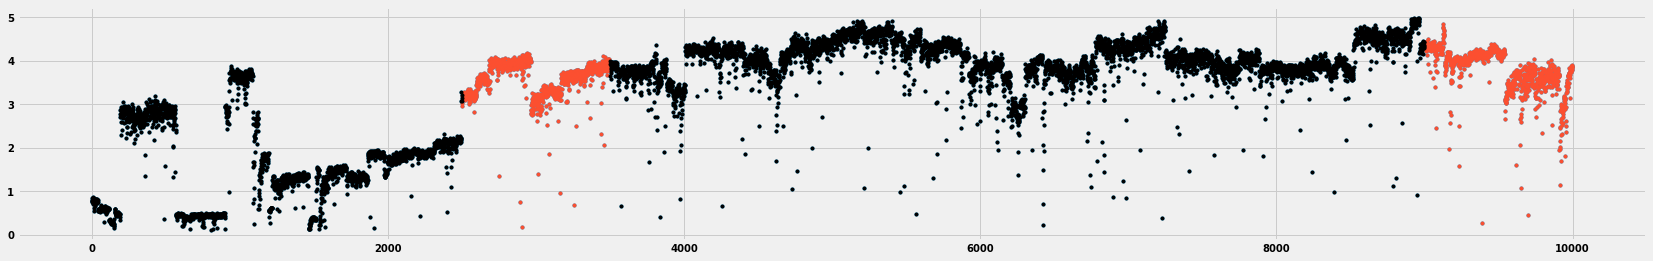

In [24]:
input_cut = input_data[n-10000:]
output_cut = output_data[n-10000:]
allinds = np.arange(0,10000)

a = 2500
b = 3500

c = 9000
d = 10000

inds_removed = np.concatenate( (np.arange(a,b), np.arange(c,d)))


plt.figure(figsize= (26,4))

plt.plot(output_cut, ".")
plt.plot(inds_removed, output_cut[inds_removed], '.')
print(np.shape(inds_removed))
print(np.shape(output_cut))

input_rem = np.delete(input_cut, inds_removed, axis = 0)
print(np.shape(input_rem))

output_rem = np.delete(output_cut, inds_removed)
print(np.shape(output_rem))

remaining = np.delete(allinds, inds_removed)

plt.plot(remaining, output_rem, '.k')
plt.show()

In [ ]:
training_models = True
PATH = ""
if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_rem, output_rem, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = input_cut

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = output_cut

    with open(PATH + "Interp2/_0.1_inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "Interp2/_0.1_outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096
    PATH = "Interp/"

    median = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "median_pred_0.1_", QUANTILE = 0.5)
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)


    upper = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "upper_pred_0.1_", QUANTILE = 0.975)
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)


    lower = qru.Model(scaling_dict = scd, PATH = PATH, NAME = "lower_pred_0.1_", QUANTILE = 0.025)
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size, saving = False)
    
    print("Completed")
else:

    PATH = ""
    MODEL_NAME = "Interp2/"
    NN = MODEL_NAME + "median_pred_0.1_Model_Weights.h5"
    LB = MODEL_NAME + "lower_pred_0.1_Model_Weights.h5"
    UB = MODEL_NAME + "upper_pred_0.1_Model_Weights.h5"

    with open(PATH + "Interp2/_0.1_inputs.pkl", 'rb') as f:
        input_dict = pickle.load(f, encoding="utf-8")

    with open(PATH + "Interp2/_0.1_outputs.pkl", 'rb') as f:
        output_dict = pickle.load(f)

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = scd)   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = scd)   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = scd)   
    lower.load()
    print("All models loaded")
    


    
    

In [ ]:
out = output_dict["test"]
median_pred = median.evaluate(input_dict["test"])
ub_pred = upper.evaluate(input_dict["test"])
lb_pred = lower.evaluate(input_dict["test"])


In [ ]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))

In [ ]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

In [ ]:
markersize = 10
plt.figure(figsize = (35, 8))
plt.plot(allinds, ub_pred[:,0], color = colors[2], alpha = 0.5, label = "Upper bound", markersize = markersize)
plt.plot(allinds, lb_pred[:,0], color = colors[2], alpha = 0.5, label = "Lower bound",markersize = markersize)
plt.plot(allinds, out, 'x', color = colors[0], alpha = 0.75 , label = "Measurements Available for Training",markersize = markersize)
plt.plot(inds_removed, out[inds_removed], 'x', color = colors[3], alpha = 0.75 , label = "Measurements Removed from Training",markersize = markersize)
plt.plot(allinds, median_pred[:,0], '.', color = colors[1], label = "Median",markersize = markersize)
plt.fill_between(allinds, ub_pred[:,0], lb_pred[:,0], color = colors[2], alpha = 0.5)
#plt.xlim(10000,30000)
plt.legend(fontsize = 20)
plt.savefig("interpolation_1.png")
plt.show()